In [86]:
%matplotlib notebook

from DataSets import *
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox
#from RegressionRun import *
import matplotlib as mpl
import pandas as pd
import numpy.ma as ma
#from MalardClient import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [116]:
# read file
dfTimeseries = pd.read_json("/home/livia/IdeaProjects/mountain-glaciers/timeseries_results/himalayas-weighted.json")
#elevation change
dfStats = gp.read_file("regression_results/himalayas-weighted.gpkg")
dfTimeseries

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue1,statistics.pointsOnDataSetValue1Ratio,statistics.pointsOnDataSetValue2,...,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered,timeseries.dates,timeseries.averages,timeseries.medians,timeseries.change
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,10.0,9.433962,96,...,-11.176451,-21.182444,-5.338712,-7.113104,106,208320,"[1288569600000, 1296518400000, 1304208000000, ...","[-15.5730685004, None, None, None, None, -31.6...","[-20.2312991556, None, None, None, None, -31.5...","[0.0, None, None, None, None, -16.0535563826, ..."
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,NaN,NaN,6,...,0.000000,0.000000,0.000000,0.000000,6,107482,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, -8.505838041, None, None, N...","[None, None, None, -8.5259349688, None, None, ...","[None, None, None, None, None, None, None, Non..."
10,-1300000,400000,100000,113.223700,763.736827,24417,0.876133,2246.0,9.198509,22171,...,-0.738574,2.042564,4.251057,1.980019,24417,80268,"[1288569600000, 1296518400000, 1304208000000, ...","[-2.035732069, 4.1826615179, -1.091154708, 0.9...","[-0.5050373437, 5.101177391, 0.311070337700000...","[0.0, 6.2183935868, 0.944577361, 2.9387705861,..."
100,-400000,0,100000,18.586732,238.207789,1595,-8.298739,51.0,3.197492,1544,...,-10.745282,-4.647542,-22.741319,0.000000,1595,3416789,"[1288569600000, 1296518400000, 1304208000000, ...","[-56.348672661, None, -4.772434362, -9.4724991...","[-74.4810125968, None, -4.5010367964, -6.50363...","[0.0, None, 51.5762382991, 46.8761735556, None..."
101,-400000,600000,100000,178.219554,1221.480705,6625,-3.062366,359.0,5.418868,6266,...,-2.934693,-2.354841,-8.571045,-6.309150,6625,3226814,"[1288569600000, 1296518400000, 1304208000000, ...","[-3.9935437596, 11.7643795429, 0.37762143, -6....","[-4.9931235422, 2.7920939062, 1.2309269901, -4...","[0.0, 15.7579233025, 4.3711651896, -2.29407050..."
102,-300000,-800000,100000,60.285411,303.781711,8308,3.862652,4774.0,57.462687,3534,...,0.924833,8.268857,12.222973,11.143885,8308,58453,"[1288569600000, 1296518400000, 1304208000000, ...","[-6.3229882871, 16.8086761381, 13.7302201896, ...","[2.7527213505, 15.8375010244, 10.51324143, 22....","[0.0, 23.1316644251, 20.0532084767, 29.2562650..."
103,-300000,-700000,100000,68.111307,545.052121,27200,0.815595,6377.0,23.444853,20823,...,-0.683550,4.001266,-3.508464,-1.406535,27200,1187524,"[1288569600000, 1296518400000, 1304208000000, ...","[2.3226210092, 5.1058240804, 4.6254973467, 0.6...","[1.1848065205, 7.0356849829, 4.1287952821, 2.2...","[0.0, 2.7832030713, 2.3028763375, -1.650591637..."
104,-300000,-600000,100000,8.505991,177.209575,8507,-1.017548,3654.0,42.952862,4853,...,-3.962692,-4.055997,-2.700972,1.014616,8507,926648,"[1288569600000, 1296518400000, 1304208000000, ...","[-1.1379820999, -13.5608637722, -5.1347301341,...","[1.3940405213, -14.7951434382, -1.9622257442, ...","[0.0, -12.4228816723, -3.9967480342, -0.573615..."
105,-300000,-500000,100000,0.326794,10.282097,532,0.856953,NaN,NaN,532,...,-13.524801,2.785189,6.112167,0.000000,532,1261806,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, 4.5798937748, 4.1712071856, None,...","[None, None, 4.5723890857, 4.2886787296, None,...","[None, None, None, None, None, None, None, Non..."
106,-300000,-300000,100000,0.754639,223.883591,13840,3.050256,768.0,5.549133,13072,...,3.469806,-0.065461,4.769503,0.000000,13840,1931109,"[1288569600000, 1296518400000, 1304208000000, ...","[2.9935274998, -3.1592530112, 3.9536766313, 7....","[3.9959211954000002, -2.8560720226000003, 3.30...","[0.0, -6.152780511, 0.9601491314, 4.4498017902..."


In [10]:
for idx, line in dfTimeseries.iloc[:2].iterrows():
    dates=[datetime.fromtimestamp(x/1000) for x in line['timeseries.dates']]

In [11]:
client = MalardClient()
parentDs = "mtngla"
inputDataSet = "ReadyHim2"
region = "himalayas"
dataSet = DataSet(parentDs=parentDs, dataSet=inputDataSet, region=region)
projection = client.getProjection(dataSet).proj4

bbx = client.boundingBox(dataSet)
minT = bbx.minT
maxT = bbx.maxT

filters = [{'column':'power','op':'gt','threshold':10000},{'column':'coh','op':'gt','threshold':0.6}, \
                    {'column':'demDiff','op':'lt','threshold':100}, {'column':'demDiffMad','op':'lt','threshold':10}, \
                    {'column':'demDiff','op':'gt','threshold':-100}, {'column':'demDiffMad','op':'gt','threshold':-10}, \
                    {'column':'refDifference','op':'gt','threshold':-150}, {'column':'refDifference','op':'lt','threshold':150}]

interval = 3
startdate = min(dates)
enddate = max(dates)

In [12]:
def getData(minX, maxX, minY, maxY):
    bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)
    result = client.executeQuery(dataSet, bbx_in, projections=[], filters=filters)
    data = PointDataSet(result.resultFileName, projection)
    dateobjects = []
    for i, row in data.data.iterrows():
        date = datetime.utcfromtimestamp(data.data.time[i])
        dateobjects.append(date)
    data.data['dateobject'] = dateobjects

    use_date = startdate
    while use_date <= enddate:
        data.data.loc[(data.data.dateobject >= use_date) & (data.data.dateobject <(use_date+relativedelta(months=+interval))), 'date_class'] = use_date
        use_date = use_date+relativedelta(months=+interval)
    return data.data


In [13]:
# plot preparation:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2
markersize = dfStats['statistics.GlacierMaskArea.pointsize']
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]



In [105]:
def plotDash(row, regression, timeseries, reg_plot, details=False, detail=None, detailtype=None):
    gridcellMinX = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minX']
    gridcellMinY = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minY']
    size = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.size']
    regression_line = dfStats[(dfStats['gridCell.minX']==gridcellMinX)&(dfStats['gridCell.minY']==gridcellMinY)]
    print('Glacier mask area: %.3f km' % (dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    print('Total points: stats={}, regression={}, w_power={}, w_power_masked={}'.format(dfTimeseries.iloc[row]['statistics.result_total'], regression_line['regression.count'].values[0], regression_line['regression.w_power.count'].values[0], regression_line['regression.w_power.count_masked'].values[0]))
    print('Points per km2: %s' % (dfTimeseries.iloc[row]['statistics.result_total']/dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    pdratio = dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask']/dfTimeseries.iloc[row]['statistics.result_total']*100
    print('Points on debris: %s  \t\t\t Points on debris ratio: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask'], pdratio))
    print('Points on TDX: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue2Ratio']))
    print('Points on SRTM: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue1Ratio']))
    #print('RSquared: %.2f' % (regression_line['regression.rsquared']))
    print('Elevation change: %.3f m/y \t Robust: %.3f m/y \t w_power: %.3f m/y \t w_coh: %.3f m/y' % (regression_line['regression.c.year'], regression_line['regression.robust.c.year'], regression_line['regression.w_power.c.year'], regression_line['regression.w_coh.c.year']))
    print('Standard error: %.3f m \t Robust: %.3f m \t w_power: %.3f m \t w_coh: %.3f m ' % (regression_line['regression.c.se.year'], regression_line['regression.robust.c.se.year'], regression_line['regression.w_power.c.se.year'], regression_line['regression.w_coh.c.se.year']))
    print('Regression constant: %.3f m \t\t Robust regression constant: %.3f m' % (regression_line['regression.const'],regression_line['regression.robust.const']))

    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]
    
    if not details:
        fig, ax = plt.subplots(2,1,figsize=(8.8,9))
    else:
        fig, ax = plt.subplots(3,1,figsize=(8.8,13.5))
    # 1 plot time series
    ax[1].plot(dates , dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)], linewidth=0.7, marker='^', markersize=2)
    

    # calculate regression prediction
    colors=['red', 'orange', 'yellow', 'green']
    for i,reg in enumerate(reg_plot):
        reg=reg+'.'
        minTime = datetime.timestamp(min(dates))
        maxTime = datetime.timestamp(max(dates))
        minTimeValue = regression_line['regression.{}c'.format(reg)].values*minTime+regression_line['regression.{}const'.format(reg)].values
        maxTimeValue = regression_line['regression.{}c'.format(reg)].values*maxTime+regression_line['regression.{}const'.format(reg)].values
        predict_v = [minTimeValue[0],maxTimeValue[0]]
    
        # add regression line
        ax[1].plot([min(dates), max(dates)], predict_v, color=colors[i], linewidth=0.5, label=reg)

    
    # more things are plotted
    if details:
        size=int(regression_line['gridCell.size'].values[0])
        minX=int(regression_line['gridCell.minX'].values[0])
        maxX=minX+size
        minY=int(regression_line['gridCell.minY'].values[0])
        maxY=minY+size
        dta = getData(minX=minX, maxX=maxX, minY=minY, maxY=maxY)
        counts=dta.groupby('date_class').index.count()
        keys = list(dta.groupby('date_class').groups.keys())
        ax_left = ax[1].twinx()
        ax_left.scatter(keys, counts, color='grey', label='counts', marker='o', s=5)
        pos = ax[2].get_position() # get the original position 
        addXAx=(pos.x1-pos.x0)/7
        #addYAx=(pos.y1-pos.y0)/6
        incX=0
        incY=0
        for i,date in enumerate(list(dta.groupby('date_class').groups.keys())):
            x=pos.x0+incX
            y=0.3+incY
            incX=incX+addXAx
            s=i+1
            if s%8==0:
                incX= 0
                incY=incY-0.06
            a = plt.axes([x, y, .07, .03], facecolor='lightgrey')
            filt=dta[dta['date_class']==date]
            if detailtype=='hist':
                filt[detail].hist()
            elif detailtype=='pie':
                filt[detail].plot.pie()
            else:
                filt[detail].plot()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize = 6)
            plt.title(i, fontsize = 7, pad=0.1)
    
        ax[2].get_xaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)
        ax[2].axis('off')
        valsNotNone = [x for x in dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)] if x is not None]
        for idx, d in enumerate(list(dta.groupby('date_class').groups.keys())):
            ax[1].annotate(idx, (d, valsNotNone[idx]), fontsize=8)
            #dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)][idx]
    
    # finish ax1
    ax[1].set_xlim(min(dates), max(dates))
    ax[1].set_xlabel('Years')
    ax[1].set_ylabel('Elevation change ({}) [m]'.format(timeseries))
    ax[1].legend()
    
    # 2 plot map
    countries.plot(ax=ax[0], edgecolor='grey', color='gainsboro', linewidth=0.5)
    rivers.plot(ax=ax[0], edgecolor='blue', linewidth=0.2)

    regression=regression+'.'
    dfStats.plot(column='regression.{}c.year'.format(regression), markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax[0])
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    ax[0].legend(handles=markers)
    leg = ax[0].legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

    #ax[0].set_ylim(-2000000, 1000000)
    #ax[0].set_xlim(-900000, 1700000)
    # add number of gridcell
    for i, txt in enumerate(dfTimeseries['statistics.result_total']):
        ax[0].annotate(i, (dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)
    # add X
    ax[0].annotate('x', (gridcellMinX+(size/2)-30000, gridcellMinY+(size/2)-30000), fontsize=12)

    if not details:
        bar=fig.colorbar(ax=ax[1], orientation='horizontal', pad=0.1, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
        bar.set_label('Elevation change per year [m]')
        plt.tight_layout()
        
    

Glacier mask area: 762.097 km
Total points: stats=109053, regression=109053.0, w_power=107460.0, w_power_masked=1593.0
Points per km2: 143.0959008295298
Points on debris: 456  			 Points on debris ratio: 0.42 percent
Points on TDX: 98.04 percent
Points on SRTM: 1.96 percent
Elevation change: -1.642 m/y 	 Robust: -1.692 m/y 	 w_power: -1.585 m/y 	 w_coh: -1.614 m/y
Standard error: 0.015 m 	 Robust: 0.012 m 	 w_power: 0.013 m 	 w_coh: 0.013 m 
Regression constant: 68.146 m 		 Robust regression constant: 70.325 m


<IPython.core.display.Javascript object>


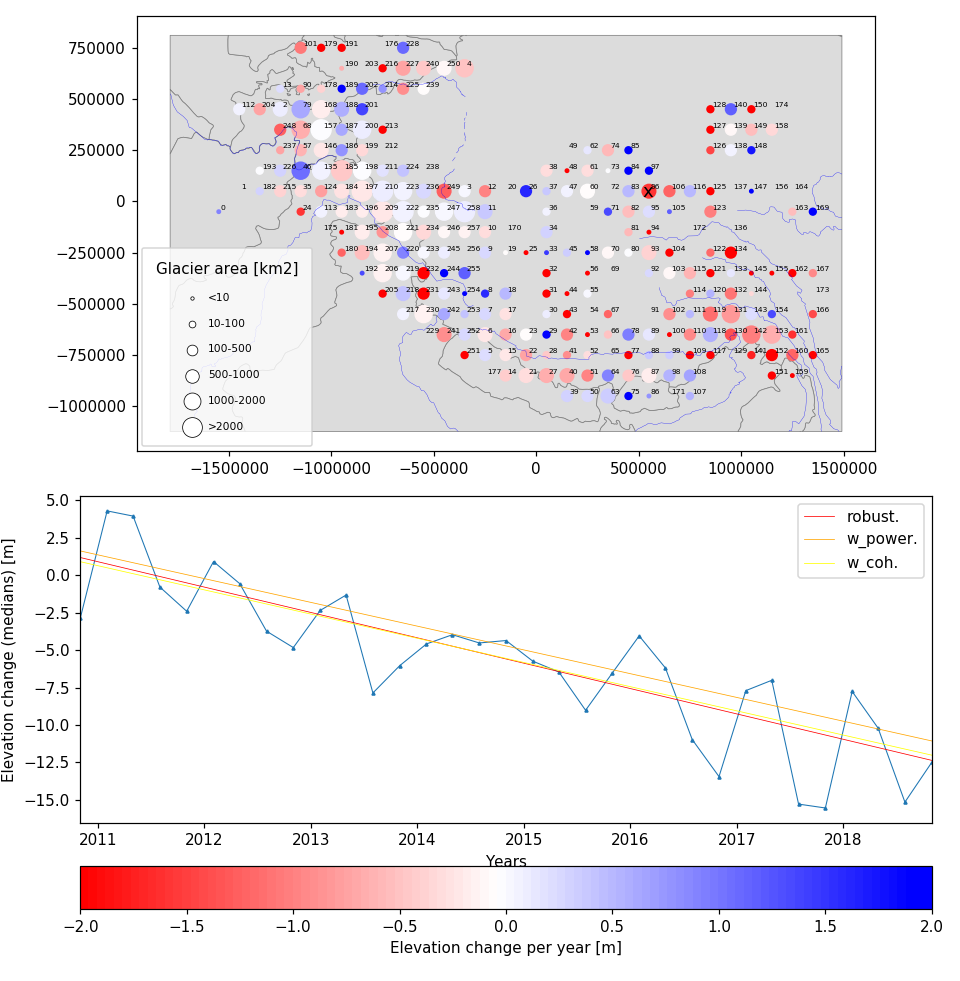

In [117]:
%matplotlib notebook
# change this
row=96
reg_map='w_power'
reg_plot=['robust','w_power','w_coh']
timeseries='medians'
plotDash(row, reg_map, timeseries, reg_plot)

Glacier mask area: 134.723 km
Total points: stats=42662, regression=42662.0, w_power=42103.0, w_power_masked=559.0
Points per km2: 316.66485108742575
Points on debris: 39  			 Points on debris ratio: 0.09 percent
Points on TDX: 99.65 percent
Points on SRTM: 0.35 percent
Elevation change: 0.444 m/y 	 Robust: 0.469 m/y 	 w_power: 0.225 m/y 	 w_coh: 0.402 m/y
Standard error: 0.024 m 	 Robust: 0.021 m 	 w_power: 0.020 m 	 w_coh: 0.021 m 
Regression constant: -20.940 m 		 Robust regression constant: -21.565 m


<IPython.core.display.Javascript object>


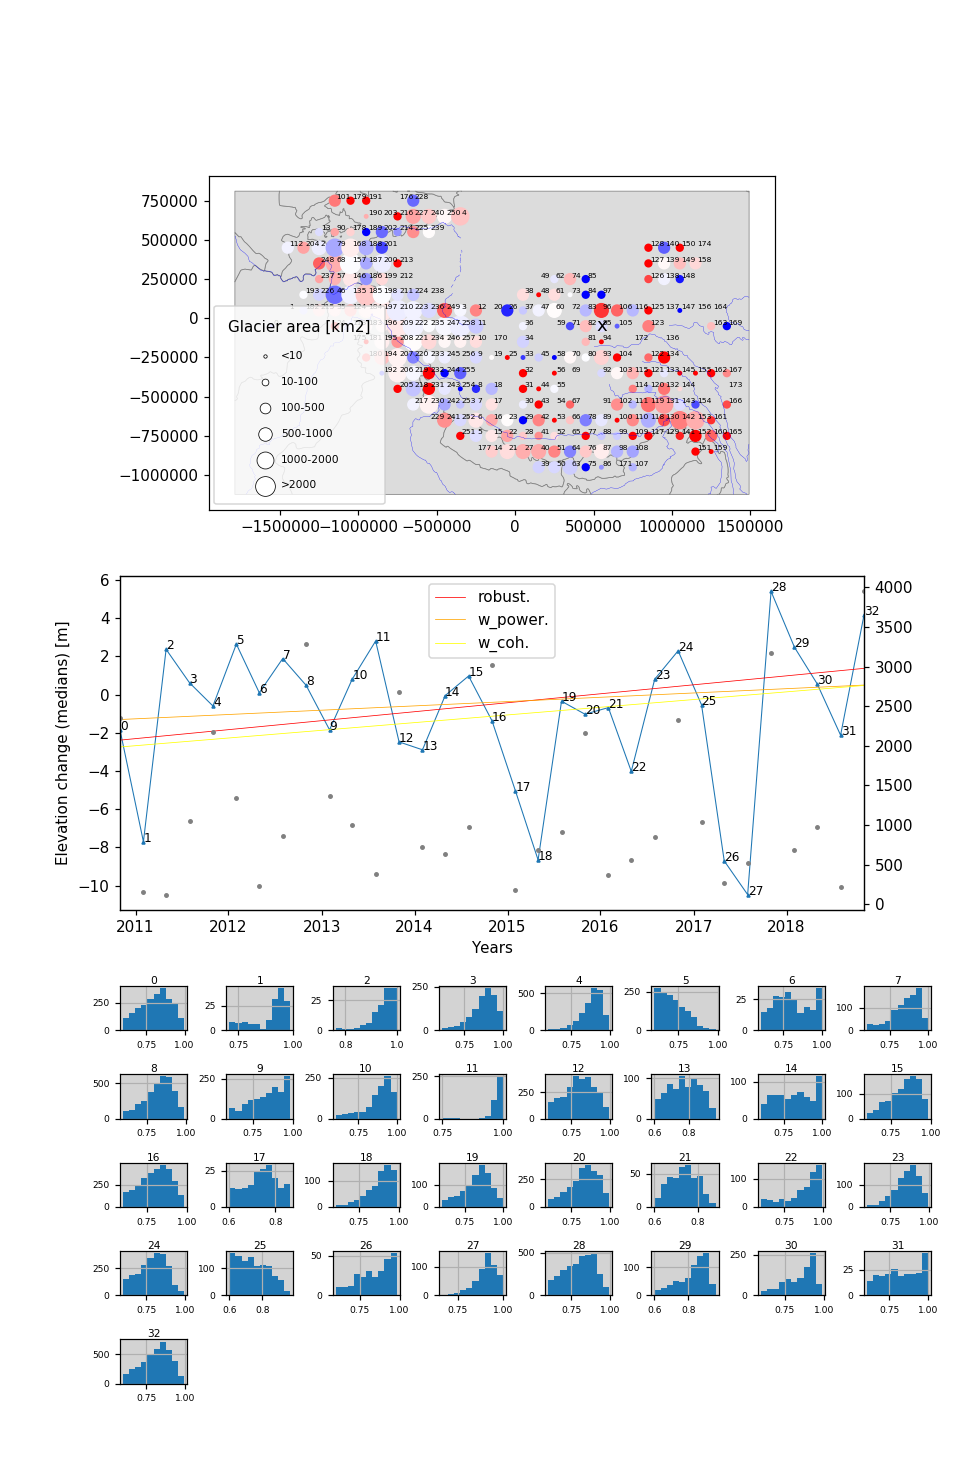

In [106]:
%matplotlib notebook
# change this
row=95
reg_map='w_power'
reg_plot=['robust','w_power','w_coh']
timeseries='medians'
plotDash(row, reg_map, timeseries, reg_plot, details=True, detail='coh', detailtype='hist')

<IPython.core.display.Javascript object>


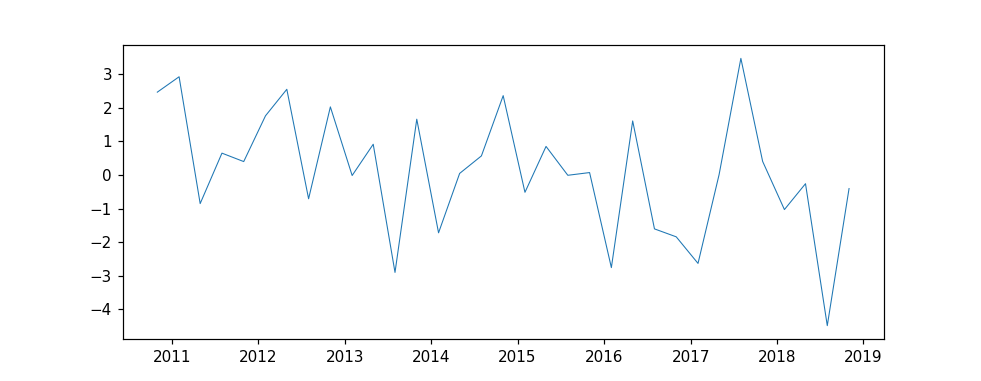

In [107]:
%matplotlib notebook
plt.figure(figsize=(9,3.5))

row=dfTimeseries.loc[(dfStats['gridCell.minX']==500000) & (dfStats['gridCell.minY']==-300000)]
 
dates=[datetime.fromtimestamp(x/1000) for x in row.iloc[0]['timeseries.dates']]
plt.plot(dates , row.iloc[0]['timeseries.averages'], linewidth=0.7)

In [108]:
def plotTS(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(8,5))
    # time series
    ax.plot(dates , dfTimeseries.iloc[row]['timeseries.averages'], linewidth=0.7)

    ax.set_xlim(min(dates), max(dates))
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean elevation difference to reference DEM [m]')
    #ax[1].yaxis.tick_right()
    #ax[1].yaxis.set_label_position("right")
    plt.title('3-Month time series')

    plt.tight_layout()
    

<IPython.core.display.Javascript object>


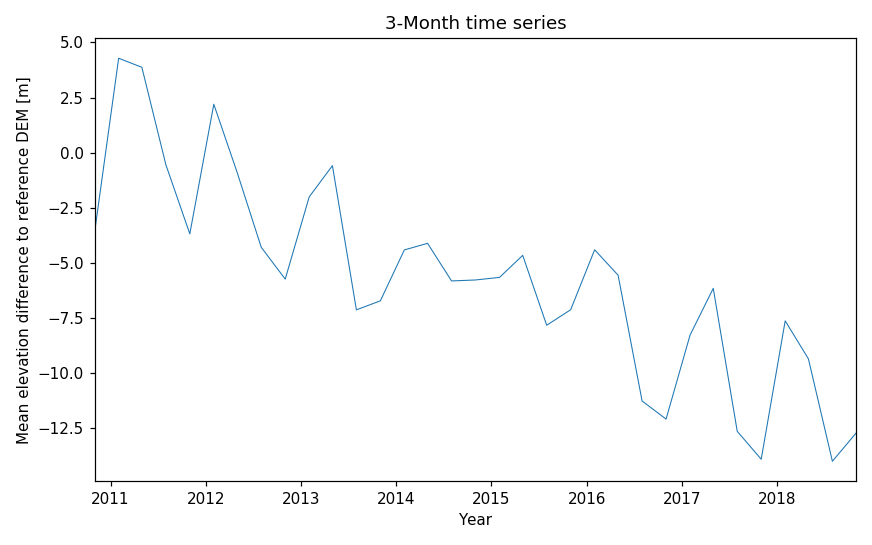

In [109]:
plotTS(96)

In [110]:
def plotMap(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(11,5.25))

    countries.plot(ax=ax, edgecolor='grey', color='lightgrey', linewidth=0.5)
    rivers.plot(ax=ax, edgecolor='blue', linewidth=0.25)

    dfStats.plot(column='regression.robust.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    #plt.title('DhDt Himalayas')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])

<IPython.core.display.Javascript object>


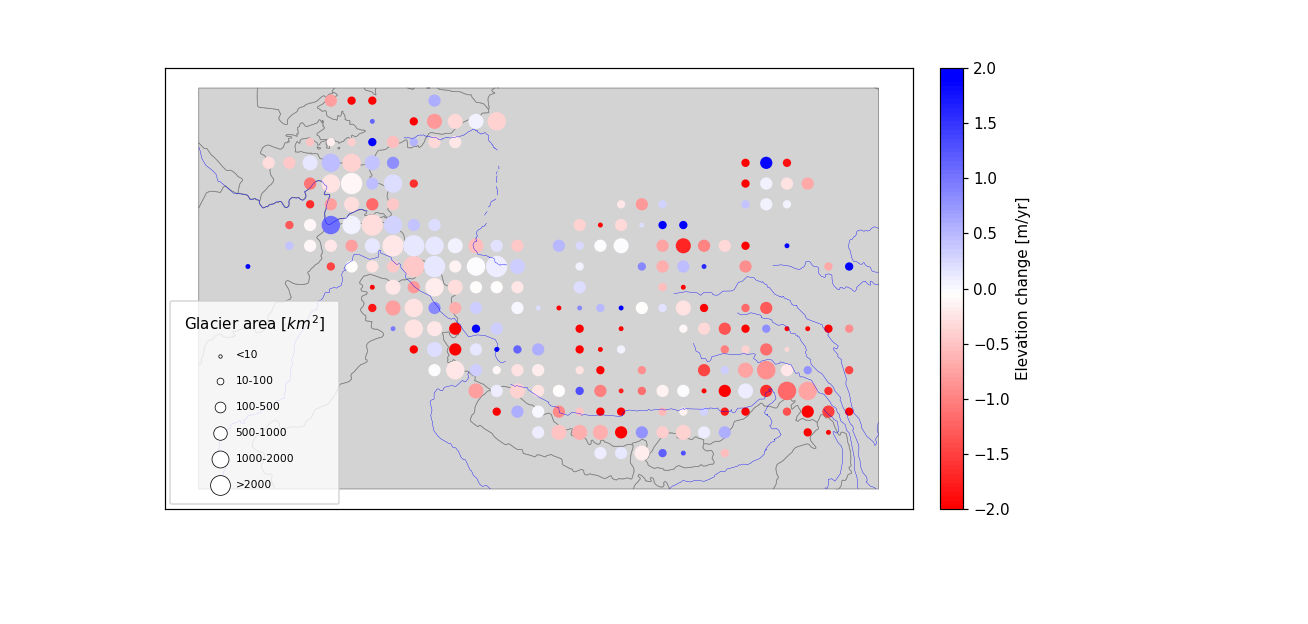

In [110]:
plotMap(0)